In [34]:
import pandas as pd
import seaborn as sns
import xgboost as xgb
import optuna as opt
import numpy as np
import os
import plotly
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from optuna.integration import XGBoostPruningCallback
import optuna.visualization as vis
import shap
from sklearn.preprocessing import StandardScaler
from optuna_dashboard import run_server

In [35]:
df = pd.read_csv("c:/Users/samud/Documents/Python_Learning/Asteroids/neo.csv/neo.csv")
df.describe()

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,9.083600e+04,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,1.438288e+07,0.127432,0.284947,48066.918918,3.706655e+07,23.527103
std,2.087202e+07,0.298511,0.667491,25293.296961,2.235204e+07,2.894086
min,2.000433e+06,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,3.448110e+06,0.019256,0.043057,28619.020645,1.721082e+07,21.340000
50%,3.748362e+06,0.048368,0.108153,44190.117890,3.784658e+07,23.700000
75%,3.884023e+06,0.143402,0.320656,62923.604633,5.654900e+07,25.700000
max,5.427591e+07,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


In [36]:
df.select_dtypes(include =["float", "int", "bool"])

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,sentry_object,absolute_magnitude,hazardous
0,2162635,1.198271,2.679415,13569.249224,5.483974e+07,False,16.73,False
1,2277475,0.265800,0.594347,73588.726663,6.143813e+07,False,20.00,True
2,2512244,0.722030,1.614507,114258.692129,4.979872e+07,False,17.83,False
3,3596030,0.096506,0.215794,24764.303138,2.543497e+07,False,22.20,False
4,3667127,0.255009,0.570217,42737.733765,4.627557e+07,False,20.09,True
...,...,...,...,...,...,...,...,...
90831,3763337,0.026580,0.059435,52078.886692,1.230039e+07,False,25.00,False
90832,3837603,0.016771,0.037501,46114.605073,5.432121e+07,False,26.00,False
90833,54017201,0.031956,0.071456,7566.807732,2.840077e+07,False,24.60,False
90834,54115824,0.007321,0.016370,69199.154484,6.869206e+07,False,27.80,False


In [37]:
#for cl in df.select_dtypes(include =["float", "int"]).columns:
 #   df.hist(column= cl)

In [38]:
## These two columns are equal along all dataset -> They are not reliable features as predictors
df = df.drop(columns=['sentry_object','orbiting_body','name','id', 'est_diameter_max'])
df = df.drop_duplicates()
df['hazardous'] = df['hazardous'].astype(int)

In [39]:
# Detected Imbalanced dataset
df['hazardous'].value_counts()

hazardous
0    81996
1     8833
Name: count, dtype: int64

In [40]:
scaler = StandardScaler()
Y = df['hazardous']
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
X = df_scaled.drop(columns='hazardous')

In [41]:
def objective(trial):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, stratify = Y, random_state = 42)
    train = xgb.DMatrix(X_train, Y_train)
    test = xgb.DMatrix(X_test, Y_test)
    
    trial.set_user_attr('X_train', X_train)
    trial.set_user_attr('X_test', X_test)
    trial.set_user_attr('Y_train', Y_train)
    trial.set_user_attr('Y_test', Y_test)

    neg_count = (Y_train == 0).sum()
    pos_count = (Y_train == 1).sum()
    scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1


    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0),
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "eta": trial.suggest_float("eta", 1e-8, 1.0),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "scale_pos_weight": scale_pos_weight
    }

    # Add a callback for pruning.
    pruning_callback = opt.integration.XGBoostPruningCallback(trial, "validation-auc")

    # Best Model
    bst = xgb.train(param, train, evals=[(test, "validation")])
    trial.set_user_attr("model", bst)
    preds = bst.predict(test)
    pred_labels = np.rint(preds)
    auc = roc_auc_score(Y_test, pred_labels)
    return auc

In [42]:
storage = opt.storages.InMemoryStorage()

study = opt.create_study(direction="maximize", storage= storage);  # Maximize AUC

study.optimize(objective, n_trials=100)

print("Best trial:")
print(f"AUC: {study.best_trial.value}")
print("Best parameters: ", study.best_trial.params)

[I 2024-12-24 11:02:27,491] A new study created in memory with name: no-name-800292e9-acb7-4bcd-ab83-de13df870f52


[0]	validation-auc:0.91057
[1]	validation-auc:0.91221
[2]	validation-auc:0.91324
[3]	validation-auc:0.91338
[4]	validation-auc:0.91411
[5]	validation-auc:0.91516
[6]	validation-auc:0.91526
[7]	validation-auc:0.91537
[8]	validation-auc:0.91613
[9]	validation-auc:0.91603


[I 2024-12-24 11:02:27,592] Trial 0 finished with value: 0.8774235271085208 and parameters: {'lambda': 0.5398228476848984, 'alpha': 0.1386825444794546, 'max_depth': 9, 'eta': 0.23827385524216274, 'gamma': 0.18532251737294844, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.8774235271085208.


[0]	validation-auc:0.90682
[1]	validation-auc:0.91276
[2]	validation-auc:0.91359
[3]	validation-auc:0.91408
[4]	validation-auc:0.91438
[5]	validation-auc:0.91524
[6]	validation-auc:0.91570
[7]	validation-auc:0.91556
[8]	validation-auc:0.91553
[9]	validation-auc:0.91819


[I 2024-12-24 11:02:27,680] Trial 1 finished with value: 0.8766441685040701 and parameters: {'lambda': 0.8739326245624404, 'alpha': 0.9010266231405415, 'max_depth': 5, 'eta': 0.8047242373545667, 'gamma': 0.11864256895487309, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.8774235271085208.


[0]	validation-auc:0.90682
[1]	validation-auc:0.91261
[2]	validation-auc:0.91380
[3]	validation-auc:0.91397
[4]	validation-auc:0.91417
[5]	validation-auc:0.91416
[6]	validation-auc:0.91476
[7]	validation-auc:0.91498
[8]	validation-auc:0.91532
[9]	validation-auc:0.91509


[I 2024-12-24 11:02:27,776] Trial 2 finished with value: 0.8747682518082509 and parameters: {'lambda': 0.9086043651176463, 'alpha': 0.7730087875249179, 'max_depth': 5, 'eta': 0.8606077459746414, 'gamma': 0.8529739565787992, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.8774235271085208.


[0]	validation-auc:0.90766
[1]	validation-auc:0.91152
[2]	validation-auc:0.91166
[3]	validation-auc:0.91322
[4]	validation-auc:0.91420
[5]	validation-auc:0.91445
[6]	validation-auc:0.91480
[7]	validation-auc:0.91406
[8]	validation-auc:0.91465
[9]	validation-auc:0.91477


[I 2024-12-24 11:02:27,871] Trial 3 finished with value: 0.8771528644771878 and parameters: {'lambda': 0.05941034823288504, 'alpha': 0.038793232847074435, 'max_depth': 6, 'eta': 0.33316919707224285, 'gamma': 0.38048086171711154, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.8774235271085208.


[0]	validation-auc:0.90775
[1]	validation-auc:0.91160
[2]	validation-auc:0.91229
[3]	validation-auc:0.91336
[4]	validation-auc:0.91426
[5]	validation-auc:0.91360
[6]	validation-auc:0.91472
[7]	validation-auc:0.91541
[8]	validation-auc:0.91560
[9]	validation-auc:0.91573


[I 2024-12-24 11:02:27,964] Trial 4 finished with value: 0.8769003886629801 and parameters: {'lambda': 0.9470614867294569, 'alpha': 0.3129412152600667, 'max_depth': 6, 'eta': 0.45858231864597215, 'gamma': 0.09518271605649901, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.8774235271085208.


[0]	validation-auc:0.90943
[1]	validation-auc:0.90977
[2]	validation-auc:0.90970
[3]	validation-auc:0.90978
[4]	validation-auc:0.91157
[5]	validation-auc:0.91189
[6]	validation-auc:0.91250
[7]	validation-auc:0.91247
[8]	validation-auc:0.91253
[9]	validation-auc:0.91250


[I 2024-12-24 11:02:28,136] Trial 5 finished with value: 0.8778407540896267 and parameters: {'lambda': 0.09449918581154952, 'alpha': 0.44748066908826173, 'max_depth': 8, 'eta': 0.04125401570649334, 'gamma': 0.4539501764077267, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.8778407540896267.


[0]	validation-auc:0.89979
[1]	validation-auc:0.90498
[2]	validation-auc:0.90771
[3]	validation-auc:0.90947
[4]	validation-auc:0.91129
[5]	validation-auc:0.91196
[6]	validation-auc:0.91198
[7]	validation-auc:0.91257
[8]	validation-auc:0.91360
[9]	validation-auc:0.91419


[I 2024-12-24 11:02:28,216] Trial 6 finished with value: 0.8780006910990508 and parameters: {'lambda': 0.7615761122993835, 'alpha': 0.2503852034435169, 'max_depth': 3, 'eta': 0.6146072491761762, 'gamma': 0.8684084439853984, 'grow_policy': 'lossguide'}. Best is trial 6 with value: 0.8780006910990508.


[0]	validation-auc:0.90957
[1]	validation-auc:0.90962
[2]	validation-auc:0.91103
[3]	validation-auc:0.91107
[4]	validation-auc:0.91147
[5]	validation-auc:0.91229
[6]	validation-auc:0.91242
[7]	validation-auc:0.91253
[8]	validation-auc:0.91276
[9]	validation-auc:0.91284


[I 2024-12-24 11:02:28,317] Trial 7 finished with value: 0.8783933123863993 and parameters: {'lambda': 0.49429896747124613, 'alpha': 0.440890592057632, 'max_depth': 7, 'eta': 0.08462781786284292, 'gamma': 0.9577632723860522, 'grow_policy': 'depthwise'}. Best is trial 7 with value: 0.8783933123863993.


[0]	validation-auc:0.90774
[1]	validation-auc:0.91231
[2]	validation-auc:0.91293
[3]	validation-auc:0.91288
[4]	validation-auc:0.91299
[5]	validation-auc:0.91407
[6]	validation-auc:0.91494
[7]	validation-auc:0.91495
[8]	validation-auc:0.91488
[9]	validation-auc:0.91491


[I 2024-12-24 11:02:28,436] Trial 8 finished with value: 0.8782847263900344 and parameters: {'lambda': 0.24238797083775626, 'alpha': 0.2636877926377177, 'max_depth': 6, 'eta': 0.37045785338680937, 'gamma': 0.8647239390186324, 'grow_policy': 'lossguide'}. Best is trial 7 with value: 0.8783933123863993.


[0]	validation-auc:0.89248
[1]	validation-auc:0.89874
[2]	validation-auc:0.90069
[3]	validation-auc:0.90406
[4]	validation-auc:0.90526
[5]	validation-auc:0.90668
[6]	validation-auc:0.91046
[7]	validation-auc:0.91047
[8]	validation-auc:0.91301
[9]	validation-auc:0.91296


[I 2024-12-24 11:02:28,534] Trial 9 finished with value: 0.8772689391629571 and parameters: {'lambda': 0.23301020529793853, 'alpha': 0.03674913981055097, 'max_depth': 2, 'eta': 0.6032561742980403, 'gamma': 0.07657236101458455, 'grow_policy': 'lossguide'}. Best is trial 7 with value: 0.8783933123863993.


[0]	validation-auc:0.90967
[1]	validation-auc:0.90957
[2]	validation-auc:0.90969
[3]	validation-auc:0.90962
[4]	validation-auc:0.91133
[5]	validation-auc:0.91225
[6]	validation-auc:0.91239
[7]	validation-auc:0.91227
[8]	validation-auc:0.91233
[9]	validation-auc:0.91241


[I 2024-12-24 11:02:28,659] Trial 10 finished with value: 0.8779541542434659 and parameters: {'lambda': 0.5561714485684843, 'alpha': 0.6320409547377825, 'max_depth': 8, 'eta': 0.03815567575583626, 'gamma': 0.6474894767902655, 'grow_policy': 'depthwise'}. Best is trial 7 with value: 0.8783933123863993.


[0]	validation-auc:0.90957
[1]	validation-auc:0.91137
[2]	validation-auc:0.91251
[3]	validation-auc:0.91250
[4]	validation-auc:0.91339
[5]	validation-auc:0.91348
[6]	validation-auc:0.91378
[7]	validation-auc:0.91426
[8]	validation-auc:0.91415
[9]	validation-auc:0.91438


[I 2024-12-24 11:02:28,804] Trial 11 finished with value: 0.8784676643740579 and parameters: {'lambda': 0.313036207336642, 'alpha': 0.44883236352367434, 'max_depth': 7, 'eta': 0.21937582249448306, 'gamma': 0.9947036392432221, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.8784676643740579.


[0]	validation-auc:0.90957
[1]	validation-auc:0.91135
[2]	validation-auc:0.91174
[3]	validation-auc:0.91272
[4]	validation-auc:0.91303
[5]	validation-auc:0.91305
[6]	validation-auc:0.91349
[7]	validation-auc:0.91411
[8]	validation-auc:0.91414
[9]	validation-auc:0.91401


[I 2024-12-24 11:02:28,959] Trial 12 finished with value: 0.8786982090264382 and parameters: {'lambda': 0.39354267918009306, 'alpha': 0.5195105142906442, 'max_depth': 7, 'eta': 0.16613515300109394, 'gamma': 0.9988592462321385, 'grow_policy': 'lossguide'}. Best is trial 12 with value: 0.8786982090264382.


[0]	validation-auc:0.91063
[1]	validation-auc:0.91263
[2]	validation-auc:0.91364
[3]	validation-auc:0.91401
[4]	validation-auc:0.91449
[5]	validation-auc:0.91430
[6]	validation-auc:0.91566
[7]	validation-auc:0.91658
[8]	validation-auc:0.91675
[9]	validation-auc:0.91706


[I 2024-12-24 11:02:29,158] Trial 13 finished with value: 0.877654071760901 and parameters: {'lambda': 0.3640358239458398, 'alpha': 0.6210967559882685, 'max_depth': 9, 'eta': 0.22377777639896457, 'gamma': 0.6462119496095329, 'grow_policy': 'lossguide'}. Best is trial 12 with value: 0.8786982090264382.


[0]	validation-auc:0.90378
[1]	validation-auc:0.90957
[2]	validation-auc:0.90909
[3]	validation-auc:0.91039
[4]	validation-auc:0.91067
[5]	validation-auc:0.91060
[6]	validation-auc:0.91044
[7]	validation-auc:0.91054
[8]	validation-auc:0.91307
[9]	validation-auc:0.91337


[I 2024-12-24 11:02:29,268] Trial 14 finished with value: 0.8771164908429376 and parameters: {'lambda': 0.38204937105376585, 'alpha': 0.6195494266230588, 'max_depth': 4, 'eta': 0.18970068193922635, 'gamma': 0.9978294775251874, 'grow_policy': 'lossguide'}. Best is trial 12 with value: 0.8786982090264382.


[0]	validation-auc:0.90960
[1]	validation-auc:0.91321
[2]	validation-auc:0.91299
[3]	validation-auc:0.91276
[4]	validation-auc:0.91335
[5]	validation-auc:0.91424
[6]	validation-auc:0.91384
[7]	validation-auc:0.91427
[8]	validation-auc:0.91587
[9]	validation-auc:0.91711


[I 2024-12-24 11:02:29,410] Trial 15 finished with value: 0.8663311733813465 and parameters: {'lambda': 0.6669049970137024, 'alpha': 0.5013418673439088, 'max_depth': 7, 'eta': 0.986509577265946, 'gamma': 0.7014396901059248, 'grow_policy': 'lossguide'}. Best is trial 12 with value: 0.8786982090264382.


[0]	validation-auc:0.87094
[1]	validation-auc:0.87238
[2]	validation-auc:0.87361
[3]	validation-auc:0.87361
[4]	validation-auc:0.87361
[5]	validation-auc:0.87361
[6]	validation-auc:0.87361
[7]	validation-auc:0.87361
[8]	validation-auc:0.87361
[9]	validation-auc:0.87361


[I 2024-12-24 11:02:29,515] Trial 16 finished with value: 0.8709393918970242 and parameters: {'lambda': 0.22351312239732593, 'alpha': 0.9994296172643942, 'max_depth': 1, 'eta': 0.15134892396341645, 'gamma': 0.7612998767165413, 'grow_policy': 'lossguide'}. Best is trial 12 with value: 0.8786982090264382.


[0]	validation-auc:0.90968
[1]	validation-auc:0.91104
[2]	validation-auc:0.91336
[3]	validation-auc:0.91389
[4]	validation-auc:0.91412
[5]	validation-auc:0.91491
[6]	validation-auc:0.91538
[7]	validation-auc:0.91613
[8]	validation-auc:0.91601
[9]	validation-auc:0.91664


[I 2024-12-24 11:02:29,648] Trial 17 finished with value: 0.8770223473189958 and parameters: {'lambda': 0.4190440422539099, 'alpha': 0.3691141192823989, 'max_depth': 7, 'eta': 0.3153939832055339, 'gamma': 0.2925757947895342, 'grow_policy': 'lossguide'}. Best is trial 12 with value: 0.8786982090264382.


[0]	validation-auc:0.90959
[1]	validation-auc:0.91213
[2]	validation-auc:0.91398
[3]	validation-auc:0.91520
[4]	validation-auc:0.91578
[5]	validation-auc:0.91705
[6]	validation-auc:0.91762
[7]	validation-auc:0.91838
[8]	validation-auc:0.91833
[9]	validation-auc:0.91776


[I 2024-12-24 11:02:29,807] Trial 18 finished with value: 0.8752523420876113 and parameters: {'lambda': 0.30464189257311375, 'alpha': 0.7539463676069249, 'max_depth': 8, 'eta': 0.4776737754690507, 'gamma': 0.6003641112438005, 'grow_policy': 'lossguide'}. Best is trial 12 with value: 0.8786982090264382.


[0]	validation-auc:0.90376
[1]	validation-auc:0.91007
[2]	validation-auc:0.90924
[3]	validation-auc:0.91135
[4]	validation-auc:0.91226
[5]	validation-auc:0.91354
[6]	validation-auc:0.91361
[7]	validation-auc:0.91383
[8]	validation-auc:0.91415
[9]	validation-auc:0.91473


[I 2024-12-24 11:02:29,917] Trial 19 finished with value: 0.8777920776084978 and parameters: {'lambda': 0.15767404506453775, 'alpha': 0.5304511487480479, 'max_depth': 4, 'eta': 0.5816483079430997, 'gamma': 0.7823920959681094, 'grow_policy': 'lossguide'}. Best is trial 12 with value: 0.8786982090264382.


[0]	validation-auc:0.90682
[1]	validation-auc:0.90890
[2]	validation-auc:0.90935
[3]	validation-auc:0.91047
[4]	validation-auc:0.91140
[5]	validation-auc:0.91146
[6]	validation-auc:0.91082
[7]	validation-auc:0.91157
[8]	validation-auc:0.91228
[9]	validation-auc:0.91216


[I 2024-12-24 11:02:30,037] Trial 20 finished with value: 0.8782750980750857 and parameters: {'lambda': 0.6547575222215691, 'alpha': 0.7392418669227112, 'max_depth': 5, 'eta': 0.12600111875635728, 'gamma': 0.5458643852801488, 'grow_policy': 'lossguide'}. Best is trial 12 with value: 0.8786982090264382.


[0]	validation-auc:0.90957
[1]	validation-auc:0.90962
[2]	validation-auc:0.90962
[3]	validation-auc:0.90963
[4]	validation-auc:0.90964
[5]	validation-auc:0.90966
[6]	validation-auc:0.90965
[7]	validation-auc:0.90972
[8]	validation-auc:0.90972
[9]	validation-auc:0.90965


[I 2024-12-24 11:02:30,163] Trial 21 finished with value: 0.8780055052565251 and parameters: {'lambda': 0.4762138371566751, 'alpha': 0.42592976376307695, 'max_depth': 7, 'eta': 0.006168202282126889, 'gamma': 0.996558552965295, 'grow_policy': 'depthwise'}. Best is trial 12 with value: 0.8786982090264382.


[0]	validation-auc:0.90956
[1]	validation-auc:0.90958
[2]	validation-auc:0.91111
[3]	validation-auc:0.91173
[4]	validation-auc:0.91238
[5]	validation-auc:0.91253
[6]	validation-auc:0.91272
[7]	validation-auc:0.91279
[8]	validation-auc:0.91283
[9]	validation-auc:0.91334


[I 2024-12-24 11:02:30,282] Trial 22 finished with value: 0.87859818153225 and parameters: {'lambda': 0.4648285926974961, 'alpha': 0.5321698145783063, 'max_depth': 7, 'eta': 0.106851174492543, 'gamma': 0.9308438740451204, 'grow_policy': 'depthwise'}. Best is trial 12 with value: 0.8786982090264382.


[0]	validation-auc:0.90977
[1]	validation-auc:0.91254
[2]	validation-auc:0.91443
[3]	validation-auc:0.91442
[4]	validation-auc:0.91581
[5]	validation-auc:0.91601
[6]	validation-auc:0.91651
[7]	validation-auc:0.91695
[8]	validation-auc:0.91658
[9]	validation-auc:0.91687


[I 2024-12-24 11:02:30,418] Trial 23 finished with value: 0.8767441959982584 and parameters: {'lambda': 0.6251128078933975, 'alpha': 0.5527843472471267, 'max_depth': 8, 'eta': 0.2900202453617343, 'gamma': 0.9091603511975537, 'grow_policy': 'depthwise'}. Best is trial 12 with value: 0.8786982090264382.


[0]	validation-auc:0.90759
[1]	validation-auc:0.91187
[2]	validation-auc:0.91228
[3]	validation-auc:0.91198
[4]	validation-auc:0.91296
[5]	validation-auc:0.91376
[6]	validation-auc:0.91420
[7]	validation-auc:0.91430
[8]	validation-auc:0.91423
[9]	validation-auc:0.91525


[I 2024-12-24 11:02:30,526] Trial 24 finished with value: 0.8765088371884037 and parameters: {'lambda': 0.3441720542681848, 'alpha': 0.3666424307061851, 'max_depth': 6, 'eta': 0.41050272388465747, 'gamma': 0.7835144279228209, 'grow_policy': 'depthwise'}. Best is trial 12 with value: 0.8786982090264382.


[0]	validation-auc:0.91063
[1]	validation-auc:0.91239
[2]	validation-auc:0.91330
[3]	validation-auc:0.91360
[4]	validation-auc:0.91406
[5]	validation-auc:0.91473
[6]	validation-auc:0.91491
[7]	validation-auc:0.91510
[8]	validation-auc:0.91539
[9]	validation-auc:0.91632


[I 2024-12-24 11:02:30,678] Trial 25 finished with value: 0.8777540992550894 and parameters: {'lambda': 0.2965709836839372, 'alpha': 0.6619454621276026, 'max_depth': 9, 'eta': 0.1369606050114757, 'gamma': 0.9270140902449218, 'grow_policy': 'lossguide'}. Best is trial 12 with value: 0.8786982090264382.


[0]	validation-auc:0.90972
[1]	validation-auc:0.91136
[2]	validation-auc:0.91237
[3]	validation-auc:0.91242
[4]	validation-auc:0.91294
[5]	validation-auc:0.91284
[6]	validation-auc:0.91329
[7]	validation-auc:0.91353
[8]	validation-auc:0.91400
[9]	validation-auc:0.91451


[I 2024-12-24 11:02:30,796] Trial 26 finished with value: 0.8788116091802773 and parameters: {'lambda': 0.4447131281596533, 'alpha': 0.14839076112450217, 'max_depth': 7, 'eta': 0.2528017887490327, 'gamma': 0.7979738227253611, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90771
[1]	validation-auc:0.91188
[2]	validation-auc:0.91381
[3]	validation-auc:0.91402
[4]	validation-auc:0.91489
[5]	validation-auc:0.91457
[6]	validation-auc:0.91524
[7]	validation-auc:0.91541
[8]	validation-auc:0.91560
[9]	validation-auc:0.91561


[I 2024-12-24 11:02:30,905] Trial 27 finished with value: 0.8781408365721916 and parameters: {'lambda': 0.4550901410874521, 'alpha': 0.16939108138706205, 'max_depth': 6, 'eta': 0.26358014223336923, 'gamma': 0.7890595390777788, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90378
[1]	validation-auc:0.90720
[2]	validation-auc:0.90973
[3]	validation-auc:0.90996
[4]	validation-auc:0.90992
[5]	validation-auc:0.91055
[6]	validation-auc:0.91051
[7]	validation-auc:0.91063
[8]	validation-auc:0.91067
[9]	validation-auc:0.91072


[I 2024-12-24 11:02:31,004] Trial 28 finished with value: 0.876689635546883 and parameters: {'lambda': 0.7536568063616454, 'alpha': 0.17289845074892274, 'max_depth': 4, 'eta': 0.09765414734670012, 'gamma': 0.7053436628047947, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.91048
[1]	validation-auc:0.91260
[2]	validation-auc:0.91358
[3]	validation-auc:0.91493
[4]	validation-auc:0.91535
[5]	validation-auc:0.91567
[6]	validation-auc:0.91575
[7]	validation-auc:0.91708
[8]	validation-auc:0.91726
[9]	validation-auc:0.91735


[I 2024-12-24 11:02:31,124] Trial 29 finished with value: 0.878019947728948 and parameters: {'lambda': 0.5564494717092593, 'alpha': 0.10302699821290445, 'max_depth': 9, 'eta': 0.1967663921507843, 'gamma': 0.8686572465605183, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90965
[1]	validation-auc:0.91228
[2]	validation-auc:0.91353
[3]	validation-auc:0.91414
[4]	validation-auc:0.91432
[5]	validation-auc:0.91611
[6]	validation-auc:0.91698
[7]	validation-auc:0.91661
[8]	validation-auc:0.91768
[9]	validation-auc:0.91802


[I 2024-12-24 11:02:31,226] Trial 30 finished with value: 0.8763708313408071 and parameters: {'lambda': 0.5831622341682675, 'alpha': 0.5584956180774135, 'max_depth': 8, 'eta': 0.3951647337056827, 'gamma': 0.0011576159634490435, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90958
[1]	validation-auc:0.91119
[2]	validation-auc:0.91235
[3]	validation-auc:0.91238
[4]	validation-auc:0.91317
[5]	validation-auc:0.91344
[6]	validation-auc:0.91399
[7]	validation-auc:0.91391
[8]	validation-auc:0.91440
[9]	validation-auc:0.91465


[I 2024-12-24 11:02:31,337] Trial 31 finished with value: 0.8783676368798696 and parameters: {'lambda': 0.4300906635134863, 'alpha': 0.3552248119559414, 'max_depth': 7, 'eta': 0.24198089965743952, 'gamma': 0.936350539688693, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90956
[1]	validation-auc:0.91134
[2]	validation-auc:0.91229
[3]	validation-auc:0.91251
[4]	validation-auc:0.91271
[5]	validation-auc:0.91272
[6]	validation-auc:0.91335
[7]	validation-auc:0.91366
[8]	validation-auc:0.91382
[9]	validation-auc:0.91372


[I 2024-12-24 11:02:31,460] Trial 32 finished with value: 0.8779017334176346 and parameters: {'lambda': 0.15387772877872063, 'alpha': 0.7006845948306896, 'max_depth': 7, 'eta': 0.1748095125801275, 'gamma': 0.9997536423937265, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90763
[1]	validation-auc:0.90762
[2]	validation-auc:0.91170
[3]	validation-auc:0.91167
[4]	validation-auc:0.91170
[5]	validation-auc:0.91208
[6]	validation-auc:0.91215
[7]	validation-auc:0.91215
[8]	validation-auc:0.91221
[9]	validation-auc:0.91237


[I 2024-12-24 11:02:31,571] Trial 33 finished with value: 0.8784238020504032 and parameters: {'lambda': 0.5123345682167747, 'alpha': 0.4733160660707839, 'max_depth': 6, 'eta': 0.0682407546116619, 'gamma': 0.8262955207292736, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90681
[1]	validation-auc:0.91033
[2]	validation-auc:0.91192
[3]	validation-auc:0.91270
[4]	validation-auc:0.91255
[5]	validation-auc:0.91456
[6]	validation-auc:0.91498
[7]	validation-auc:0.91709
[8]	validation-auc:0.91712
[9]	validation-auc:0.91754


[I 2024-12-24 11:02:31,681] Trial 34 finished with value: 0.8772272164648465 and parameters: {'lambda': 0.3038926335591106, 'alpha': 0.2319369683395267, 'max_depth': 5, 'eta': 0.7054096999651515, 'gamma': 0.9151404875999712, 'grow_policy': 'lossguide'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90977
[1]	validation-auc:0.91272
[2]	validation-auc:0.91405
[3]	validation-auc:0.91443
[4]	validation-auc:0.91492
[5]	validation-auc:0.91536
[6]	validation-auc:0.91563
[7]	validation-auc:0.91587
[8]	validation-auc:0.91723
[9]	validation-auc:0.91704


[I 2024-12-24 11:02:31,815] Trial 35 finished with value: 0.8784334303653517 and parameters: {'lambda': 0.4135123354416107, 'alpha': 0.8272713585561312, 'max_depth': 8, 'eta': 0.3254517152806052, 'gamma': 0.8271924434088733, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90957
[1]	validation-auc:0.91133
[2]	validation-auc:0.91245
[3]	validation-auc:0.91243
[4]	validation-auc:0.91324
[5]	validation-auc:0.91330
[6]	validation-auc:0.91324
[7]	validation-auc:0.91411
[8]	validation-auc:0.91433
[9]	validation-auc:0.91467


[I 2024-12-24 11:02:32,074] Trial 36 finished with value: 0.8783590783776931 and parameters: {'lambda': 0.34763195992652923, 'alpha': 0.5745775078735926, 'max_depth': 7, 'eta': 0.2468321841432647, 'gamma': 0.9499400538796732, 'grow_policy': 'lossguide'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90771
[1]	validation-auc:0.90773
[2]	validation-auc:0.90772
[3]	validation-auc:0.90773
[4]	validation-auc:0.90771
[5]	validation-auc:0.90773
[6]	validation-auc:0.90771
[7]	validation-auc:0.90773
[8]	validation-auc:0.90771
[9]	validation-auc:0.90773


[I 2024-12-24 11:02:32,194] Trial 37 finished with value: 0.8781274639125407 and parameters: {'lambda': 0.0196009159590399, 'alpha': 0.8248011120138158, 'max_depth': 6, 'eta': 0.005900114608791557, 'gamma': 0.3096341129556556, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90965
[1]	validation-auc:0.90974
[2]	validation-auc:0.91167
[3]	validation-auc:0.91211
[4]	validation-auc:0.91239
[5]	validation-auc:0.91399
[6]	validation-auc:0.91395
[7]	validation-auc:0.91406
[8]	validation-auc:0.91410
[9]	validation-auc:0.91500


[I 2024-12-24 11:02:32,373] Trial 38 finished with value: 0.8772357749670231 and parameters: {'lambda': 0.7384133771256196, 'alpha': 0.30309670286284135, 'max_depth': 8, 'eta': 0.12559004220950265, 'gamma': 0.7323700486815775, 'grow_policy': 'lossguide'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90681
[1]	validation-auc:0.91107
[2]	validation-auc:0.91210
[3]	validation-auc:0.91242
[4]	validation-auc:0.91297
[5]	validation-auc:0.91350
[6]	validation-auc:0.91406
[7]	validation-auc:0.91408
[8]	validation-auc:0.91399
[9]	validation-auc:0.91423


[I 2024-12-24 11:02:32,502] Trial 39 finished with value: 0.8783799397267484 and parameters: {'lambda': 0.5084259501783417, 'alpha': 0.003928934343442436, 'max_depth': 5, 'eta': 0.3639165717992614, 'gamma': 0.45794575801696263, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.91066
[1]	validation-auc:0.91272
[2]	validation-auc:0.91545
[3]	validation-auc:0.91687
[4]	validation-auc:0.91759
[5]	validation-auc:0.91777
[6]	validation-auc:0.91899
[7]	validation-auc:0.91867
[8]	validation-auc:0.91874
[9]	validation-auc:0.91799


[I 2024-12-24 11:02:32,706] Trial 40 finished with value: 0.8687863936932397 and parameters: {'lambda': 0.601109998913901, 'alpha': 0.4112101945056659, 'max_depth': 9, 'eta': 0.5607104365135811, 'gamma': 0.8830138803412402, 'grow_policy': 'lossguide'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90977
[1]	validation-auc:0.91254
[2]	validation-auc:0.91404
[3]	validation-auc:0.91458
[4]	validation-auc:0.91528
[5]	validation-auc:0.91583
[6]	validation-auc:0.91558
[7]	validation-auc:0.91587
[8]	validation-auc:0.91628
[9]	validation-auc:0.91588


[I 2024-12-24 11:02:32,833] Trial 41 finished with value: 0.8779284787369364 and parameters: {'lambda': 0.41007071643427245, 'alpha': 0.8237641648699535, 'max_depth': 8, 'eta': 0.30573368134252443, 'gamma': 0.8022530658992856, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90986
[1]	validation-auc:0.91209
[2]	validation-auc:0.91427
[3]	validation-auc:0.91509
[4]	validation-auc:0.91549
[5]	validation-auc:0.91555
[6]	validation-auc:0.91659
[7]	validation-auc:0.91707
[8]	validation-auc:0.91718
[9]	validation-auc:0.91754


[I 2024-12-24 11:02:32,956] Trial 42 finished with value: 0.8763098520127992 and parameters: {'lambda': 0.46641304616610046, 'alpha': 0.9554924906886701, 'max_depth': 7, 'eta': 0.44541595813702445, 'gamma': 0.8450410031003524, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90976
[1]	validation-auc:0.91215
[2]	validation-auc:0.91384
[3]	validation-auc:0.91538
[4]	validation-auc:0.91514
[5]	validation-auc:0.91576
[6]	validation-auc:0.91581
[7]	validation-auc:0.91561
[8]	validation-auc:0.91700
[9]	validation-auc:0.91751


[I 2024-12-24 11:02:33,073] Trial 43 finished with value: 0.8740193828678042 and parameters: {'lambda': 0.3935739200365816, 'alpha': 0.9178224194182669, 'max_depth': 8, 'eta': 0.3492690778517141, 'gamma': 0.8974291231786053, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90972
[1]	validation-auc:0.91148
[2]	validation-auc:0.91251
[3]	validation-auc:0.91244
[4]	validation-auc:0.91276
[5]	validation-auc:0.91341
[6]	validation-auc:0.91318
[7]	validation-auc:0.91391
[8]	validation-auc:0.91410
[9]	validation-auc:0.91447


[I 2024-12-24 11:02:33,196] Trial 44 finished with value: 0.8783676368798696 and parameters: {'lambda': 0.2815493462536649, 'alpha': 0.10883207037909326, 'max_depth': 7, 'eta': 0.20990184917166238, 'gamma': 0.9590939890432713, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90958
[1]	validation-auc:0.91212
[2]	validation-auc:0.91417
[3]	validation-auc:0.91434
[4]	validation-auc:0.91543
[5]	validation-auc:0.91539
[6]	validation-auc:0.91579
[7]	validation-auc:0.91611
[8]	validation-auc:0.91740
[9]	validation-auc:0.91770


[I 2024-12-24 11:02:33,330] Trial 45 finished with value: 0.8776845614249051 and parameters: {'lambda': 0.20531905336201983, 'alpha': 0.6846611440262103, 'max_depth': 8, 'eta': 0.27640127268122905, 'gamma': 0.8422265149089427, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90760
[1]	validation-auc:0.90762
[2]	validation-auc:0.91172
[3]	validation-auc:0.91153
[4]	validation-auc:0.91157
[5]	validation-auc:0.91197
[6]	validation-auc:0.91220
[7]	validation-auc:0.91217
[8]	validation-auc:0.91374
[9]	validation-auc:0.91370


[I 2024-12-24 11:02:33,470] Trial 46 finished with value: 0.8784323605525797 and parameters: {'lambda': 0.3430042242343757, 'alpha': 0.8276918287696815, 'max_depth': 6, 'eta': 0.07722895887029231, 'gamma': 0.9600040521779274, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90962
[1]	validation-auc:0.91132
[2]	validation-auc:0.91234
[3]	validation-auc:0.91230
[4]	validation-auc:0.91241
[5]	validation-auc:0.91245
[6]	validation-auc:0.91316
[7]	validation-auc:0.91339
[8]	validation-auc:0.91371
[9]	validation-auc:0.91368


[I 2024-12-24 11:02:33,596] Trial 47 finished with value: 0.8781542092318424 and parameters: {'lambda': 0.8349236979913266, 'alpha': 0.5056359921682173, 'max_depth': 7, 'eta': 0.17311146899537644, 'gamma': 0.6632332622550374, 'grow_policy': 'lossguide'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.91063
[1]	validation-auc:0.91186
[2]	validation-auc:0.91348
[3]	validation-auc:0.91309
[4]	validation-auc:0.91330
[5]	validation-auc:0.91434
[6]	validation-auc:0.91701
[7]	validation-auc:0.91690
[8]	validation-auc:0.91700
[9]	validation-auc:0.91776


[I 2024-12-24 11:02:33,807] Trial 48 finished with value: 0.876001211028058 and parameters: {'lambda': 0.5397891534450865, 'alpha': 0.27904402380571625, 'max_depth': 9, 'eta': 0.3334973100104781, 'gamma': 0.5895758539573823, 'grow_policy': 'lossguide'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90959
[1]	validation-auc:0.91209
[2]	validation-auc:0.91483
[3]	validation-auc:0.91488
[4]	validation-auc:0.91643
[5]	validation-auc:0.91787
[6]	validation-auc:0.91813
[7]	validation-auc:0.91817
[8]	validation-auc:0.91788
[9]	validation-auc:0.91775


[I 2024-12-24 11:02:33,926] Trial 49 finished with value: 0.8735727360354664 and parameters: {'lambda': 0.44418274230845706, 'alpha': 0.5793188907606628, 'max_depth': 8, 'eta': 0.5324164374307125, 'gamma': 0.7443513516567064, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90682
[1]	validation-auc:0.90903
[2]	validation-auc:0.91082
[3]	validation-auc:0.91080
[4]	validation-auc:0.91016
[5]	validation-auc:0.91094
[6]	validation-auc:0.91077
[7]	validation-auc:0.91123
[8]	validation-auc:0.91251
[9]	validation-auc:0.91357


[I 2024-12-24 11:02:34,036] Trial 50 finished with value: 0.8781836290830741 and parameters: {'lambda': 0.9980134255438178, 'alpha': 0.21766826934858938, 'max_depth': 5, 'eta': 0.2037014691412965, 'gamma': 0.8279355329107172, 'grow_policy': 'lossguide'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90760
[1]	validation-auc:0.91182
[2]	validation-auc:0.91171
[3]	validation-auc:0.91220
[4]	validation-auc:0.91223
[5]	validation-auc:0.91376
[6]	validation-auc:0.91393
[7]	validation-auc:0.91397
[8]	validation-auc:0.91446
[9]	validation-auc:0.91483


[I 2024-12-24 11:02:34,161] Trial 51 finished with value: 0.8783189603987406 and parameters: {'lambda': 0.3486948240121779, 'alpha': 0.8061291811986627, 'max_depth': 6, 'eta': 0.1208441216283345, 'gamma': 0.9620082323079169, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90971
[1]	validation-auc:0.90974
[2]	validation-auc:0.91119
[3]	validation-auc:0.91114
[4]	validation-auc:0.91130
[5]	validation-auc:0.91221
[6]	validation-auc:0.91239
[7]	validation-auc:0.91249
[8]	validation-auc:0.91251
[9]	validation-auc:0.91253


[I 2024-12-24 11:02:34,284] Trial 52 finished with value: 0.8785676918682461 and parameters: {'lambda': 0.2717398555760706, 'alpha': 0.8641185789942218, 'max_depth': 7, 'eta': 0.0659845779123926, 'gamma': 0.9657454274869375, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90971
[1]	validation-auc:0.90975
[2]	validation-auc:0.91120
[3]	validation-auc:0.91114
[4]	validation-auc:0.91130
[5]	validation-auc:0.91225
[6]	validation-auc:0.91243
[7]	validation-auc:0.91250
[8]	validation-auc:0.91253
[9]	validation-auc:0.91252


[I 2024-12-24 11:02:34,407] Trial 53 finished with value: 0.8785676918682461 and parameters: {'lambda': 0.2637134779376658, 'alpha': 0.884423708653457, 'max_depth': 7, 'eta': 0.0662828109224107, 'gamma': 0.8903639885844359, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90970
[1]	validation-auc:0.90973
[2]	validation-auc:0.90974
[3]	validation-auc:0.90973
[4]	validation-auc:0.91106
[5]	validation-auc:0.91092
[6]	validation-auc:0.91131
[7]	validation-auc:0.91141
[8]	validation-auc:0.91143
[9]	validation-auc:0.91174


[I 2024-12-24 11:02:34,529] Trial 54 finished with value: 0.8782713537303837 and parameters: {'lambda': 0.17942057303040387, 'alpha': 0.8776114065591101, 'max_depth': 7, 'eta': 0.03746954047765737, 'gamma': 0.9951931088677821, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90973
[1]	validation-auc:0.90975
[2]	validation-auc:0.90976
[3]	validation-auc:0.91116
[4]	validation-auc:0.91112
[5]	validation-auc:0.91132
[6]	validation-auc:0.91130
[7]	validation-auc:0.91185
[8]	validation-auc:0.91189
[9]	validation-auc:0.91211


[I 2024-12-24 11:02:34,649] Trial 55 finished with value: 0.877653001948129 and parameters: {'lambda': 0.26957705561968576, 'alpha': 0.9820022066810355, 'max_depth': 7, 'eta': 0.04136021975077346, 'gamma': 0.8895978300162157, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90760
[1]	validation-auc:0.91181
[2]	validation-auc:0.91185
[3]	validation-auc:0.91197
[4]	validation-auc:0.91219
[5]	validation-auc:0.91238
[6]	validation-auc:0.91258
[7]	validation-auc:0.91333
[8]	validation-auc:0.91321
[9]	validation-auc:0.91398


[I 2024-12-24 11:02:34,763] Trial 56 finished with value: 0.8781274639125407 and parameters: {'lambda': 0.11301429424152915, 'alpha': 0.876549670963997, 'max_depth': 6, 'eta': 0.15204720411908934, 'gamma': 0.9356335051921219, 'grow_policy': 'lossguide'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.89979
[1]	validation-auc:0.90336
[2]	validation-auc:0.90338
[3]	validation-auc:0.90364
[4]	validation-auc:0.90525
[5]	validation-auc:0.90525
[6]	validation-auc:0.90545
[7]	validation-auc:0.90535
[8]	validation-auc:0.90543
[9]	validation-auc:0.90548


[I 2024-12-24 11:02:34,859] Trial 57 finished with value: 0.8766591458828792 and parameters: {'lambda': 0.24431867125571766, 'alpha': 0.6130994021393502, 'max_depth': 3, 'eta': 0.08724082670316241, 'gamma': 0.8784607598749952, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90969
[1]	validation-auc:0.90974
[2]	validation-auc:0.90966
[3]	validation-auc:0.91112
[4]	validation-auc:0.91103
[5]	validation-auc:0.91126
[6]	validation-auc:0.91178
[7]	validation-auc:0.91220
[8]	validation-auc:0.91240
[9]	validation-auc:0.91247


[I 2024-12-24 11:02:34,983] Trial 58 finished with value: 0.8783847538842227 and parameters: {'lambda': 0.31139682381985984, 'alpha': 0.7267606947779315, 'max_depth': 7, 'eta': 0.052135492800819416, 'gamma': 0.9733581071341455, 'grow_policy': 'lossguide'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90760
[1]	validation-auc:0.90761
[2]	validation-auc:0.90761
[3]	validation-auc:0.90761
[4]	validation-auc:0.90761
[5]	validation-auc:0.90761
[6]	validation-auc:0.90761
[7]	validation-auc:0.90761
[8]	validation-auc:0.90761
[9]	validation-auc:0.90761


[I 2024-12-24 11:02:35,107] Trial 59 finished with value: 0.8780359949205291 and parameters: {'lambda': 0.25583039585932293, 'alpha': 0.9305568879970147, 'max_depth': 6, 'eta': 0.0014628280687435241, 'gamma': 0.9210442273754174, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90972
[1]	validation-auc:0.91151
[2]	validation-auc:0.91172
[3]	validation-auc:0.91246
[4]	validation-auc:0.91282
[5]	validation-auc:0.91280
[6]	validation-auc:0.91341
[7]	validation-auc:0.91306
[8]	validation-auc:0.91350
[9]	validation-auc:0.91378


[I 2024-12-24 11:02:35,227] Trial 60 finished with value: 0.8779798297499954 and parameters: {'lambda': 0.3823288960133711, 'alpha': 0.3983845335644549, 'max_depth': 7, 'eta': 0.16122617679083992, 'gamma': 0.23479520767171214, 'grow_policy': 'lossguide'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90977
[1]	validation-auc:0.91233
[2]	validation-auc:0.91418
[3]	validation-auc:0.91386
[4]	validation-auc:0.91478
[5]	validation-auc:0.91486
[6]	validation-auc:0.91558
[7]	validation-auc:0.91592
[8]	validation-auc:0.91592
[9]	validation-auc:0.91634


[I 2024-12-24 11:02:35,340] Trial 61 finished with value: 0.878167581891493 and parameters: {'lambda': 0.41984124169521786, 'alpha': 0.7813950311397476, 'max_depth': 8, 'eta': 0.24069696856360534, 'gamma': 0.8085150439910498, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90977
[1]	validation-auc:0.90981
[2]	validation-auc:0.91152
[3]	validation-auc:0.91207
[4]	validation-auc:0.91222
[5]	validation-auc:0.91326
[6]	validation-auc:0.91356
[7]	validation-auc:0.91421
[8]	validation-auc:0.91420
[9]	validation-auc:0.91444


[I 2024-12-24 11:02:35,470] Trial 62 finished with value: 0.8781456507296658 and parameters: {'lambda': 0.3239720170379439, 'alpha': 0.8583806428506457, 'max_depth': 8, 'eta': 0.09712751147302336, 'gamma': 0.859195894764163, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90957
[1]	validation-auc:0.90962
[2]	validation-auc:0.91112
[3]	validation-auc:0.91173
[4]	validation-auc:0.91245
[5]	validation-auc:0.91255
[6]	validation-auc:0.91288
[7]	validation-auc:0.91293
[8]	validation-auc:0.91353
[9]	validation-auc:0.91358


[I 2024-12-24 11:02:35,583] Trial 63 finished with value: 0.8782932848922108 and parameters: {'lambda': 0.48822051063653527, 'alpha': 0.46158976596269274, 'max_depth': 7, 'eta': 0.11426279179219508, 'gamma': 0.9065380027612191, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90986
[1]	validation-auc:0.91281
[2]	validation-auc:0.91399
[3]	validation-auc:0.91430
[4]	validation-auc:0.91396
[5]	validation-auc:0.91768
[6]	validation-auc:0.91752
[7]	validation-auc:0.91848
[8]	validation-auc:0.91975
[9]	validation-auc:0.92026


[I 2024-12-24 11:02:35,727] Trial 64 finished with value: 0.8764633701455907 and parameters: {'lambda': 0.3778918174435514, 'alpha': 0.9514807825892706, 'max_depth': 7, 'eta': 0.6637585975466944, 'gamma': 0.9911915367491884, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90977
[1]	validation-auc:0.91211
[2]	validation-auc:0.91349
[3]	validation-auc:0.91336
[4]	validation-auc:0.91375
[5]	validation-auc:0.91373
[6]	validation-auc:0.91459
[7]	validation-auc:0.91528
[8]	validation-auc:0.91592
[9]	validation-auc:0.91612


[I 2024-12-24 11:02:35,852] Trial 65 finished with value: 0.87834196137334 and parameters: {'lambda': 0.45319429103028563, 'alpha': 0.7714293836062395, 'max_depth': 8, 'eta': 0.2224408797668055, 'gamma': 0.9337235597219832, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90760
[1]	validation-auc:0.91179
[2]	validation-auc:0.91216
[3]	validation-auc:0.91225
[4]	validation-auc:0.91303
[5]	validation-auc:0.91434
[6]	validation-auc:0.91470
[7]	validation-auc:0.91517
[8]	validation-auc:0.91558
[9]	validation-auc:0.91541


[I 2024-12-24 11:02:35,971] Trial 66 finished with value: 0.8779712712478188 and parameters: {'lambda': 0.21438695578941108, 'alpha': 0.9014359195973489, 'max_depth': 6, 'eta': 0.28201283343506345, 'gamma': 0.7750980622464636, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.91067
[1]	validation-auc:0.91255
[2]	validation-auc:0.91367
[3]	validation-auc:0.91392
[4]	validation-auc:0.91487
[5]	validation-auc:0.91528
[6]	validation-auc:0.91745
[7]	validation-auc:0.91724
[8]	validation-auc:0.91704
[9]	validation-auc:0.91750


[I 2024-12-24 11:02:36,110] Trial 67 finished with value: 0.8768575961520974 and parameters: {'lambda': 0.522121908434944, 'alpha': 0.6609423288229179, 'max_depth': 9, 'eta': 0.18723990830290826, 'gamma': 0.861858002284038, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90960
[1]	validation-auc:0.91225
[2]	validation-auc:0.91432
[3]	validation-auc:0.91427
[4]	validation-auc:0.91460
[5]	validation-auc:0.91457
[6]	validation-auc:0.91416
[7]	validation-auc:0.91454
[8]	validation-auc:0.91482
[9]	validation-auc:0.91489


[I 2024-12-24 11:02:36,245] Trial 68 finished with value: 0.8768051753262661 and parameters: {'lambda': 0.11891076538775727, 'alpha': 0.506007387535341, 'max_depth': 7, 'eta': 0.4211729519721513, 'gamma': 0.7121076719852635, 'grow_policy': 'lossguide'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90972
[1]	validation-auc:0.91131
[2]	validation-auc:0.91219
[3]	validation-auc:0.91290
[4]	validation-auc:0.91385
[5]	validation-auc:0.91850
[6]	validation-auc:0.91842
[7]	validation-auc:0.91760
[8]	validation-auc:0.91743
[9]	validation-auc:0.91770


[I 2024-12-24 11:02:36,369] Trial 69 finished with value: 0.8688045805103649 and parameters: {'lambda': 0.4050382928428821, 'alpha': 0.33596629951590506, 'max_depth': 8, 'eta': 0.9128974028260979, 'gamma': 0.3762479159563153, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.87094
[1]	validation-auc:0.87238
[2]	validation-auc:0.87361
[3]	validation-auc:0.87361
[4]	validation-auc:0.87361
[5]	validation-auc:0.87361
[6]	validation-auc:0.87361
[7]	validation-auc:0.87361
[8]	validation-auc:0.87361
[9]	validation-auc:0.87361


[I 2024-12-24 11:02:36,470] Trial 70 finished with value: 0.8709393918970242 and parameters: {'lambda': 0.27924513497054704, 'alpha': 0.8569819807787866, 'max_depth': 1, 'eta': 0.14124552529782325, 'gamma': 0.9746197856457351, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90760
[1]	validation-auc:0.90760
[2]	validation-auc:0.90761
[3]	validation-auc:0.91168
[4]	validation-auc:0.91166
[5]	validation-auc:0.91167
[6]	validation-auc:0.91157
[7]	validation-auc:0.91171
[8]	validation-auc:0.91208
[9]	validation-auc:0.91383


[I 2024-12-24 11:02:36,584] Trial 71 finished with value: 0.8782932848922108 and parameters: {'lambda': 0.34495879427641907, 'alpha': 0.8049641155012603, 'max_depth': 6, 'eta': 0.04846702462696101, 'gamma': 0.948943678743308, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90760
[1]	validation-auc:0.90762
[2]	validation-auc:0.91172
[3]	validation-auc:0.91153
[4]	validation-auc:0.91157
[5]	validation-auc:0.91197
[6]	validation-auc:0.91220
[7]	validation-auc:0.91215
[8]	validation-auc:0.91230
[9]	validation-auc:0.91256


[I 2024-12-24 11:02:36,703] Trial 72 finished with value: 0.8784323605525797 and parameters: {'lambda': 0.32545963171843584, 'alpha': 0.8430424937046243, 'max_depth': 6, 'eta': 0.07548427907909229, 'gamma': 0.8971114288283599, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90760
[1]	validation-auc:0.90762
[2]	validation-auc:0.91191
[3]	validation-auc:0.91196
[4]	validation-auc:0.91200
[5]	validation-auc:0.91178
[6]	validation-auc:0.91222
[7]	validation-auc:0.91225
[8]	validation-auc:0.91354
[9]	validation-auc:0.91369


[I 2024-12-24 11:02:36,813] Trial 73 finished with value: 0.8787677468566226 and parameters: {'lambda': 0.36292931599983436, 'alpha': 0.7143987295224592, 'max_depth': 6, 'eta': 0.09976775441570906, 'gamma': 0.9677363929283285, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90957
[1]	validation-auc:0.90958
[2]	validation-auc:0.91111
[3]	validation-auc:0.91170
[4]	validation-auc:0.91236
[5]	validation-auc:0.91245
[6]	validation-auc:0.91270
[7]	validation-auc:0.91278
[8]	validation-auc:0.91319
[9]	validation-auc:0.91356


[I 2024-12-24 11:02:36,928] Trial 74 finished with value: 0.8782847263900344 and parameters: {'lambda': 0.36612764146205723, 'alpha': 0.5967995126280798, 'max_depth': 7, 'eta': 0.10923466871591901, 'gamma': 0.9217713313551599, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.8788116091802773.


[0]	validation-auc:0.90971
[1]	validation-auc:0.91147
[2]	validation-auc:0.91197
[3]	validation-auc:0.91247
[4]	validation-auc:0.91274
[5]	validation-auc:0.91275
[6]	validation-auc:0.91325
[7]	validation-auc:0.91396
[8]	validation-auc:0.91371
[9]	validation-auc:0.91376


[I 2024-12-24 11:02:37,049] Trial 75 finished with value: 0.8789201951766423 and parameters: {'lambda': 0.4797103135051677, 'alpha': 0.7447013985246016, 'max_depth': 7, 'eta': 0.163782035851141, 'gamma': 0.8251073950066338, 'grow_policy': 'depthwise'}. Best is trial 75 with value: 0.8789201951766423.


[0]	validation-auc:0.90972
[1]	validation-auc:0.90975
[2]	validation-auc:0.90976
[3]	validation-auc:0.90979
[4]	validation-auc:0.90979
[5]	validation-auc:0.90987
[6]	validation-auc:0.91110
[7]	validation-auc:0.91109
[8]	validation-auc:0.91117
[9]	validation-auc:0.91121


[I 2024-12-24 11:02:37,173] Trial 76 finished with value: 0.8778530569365056 and parameters: {'lambda': 0.5745230795202816, 'alpha': 0.7204576759399036, 'max_depth': 7, 'eta': 0.02111193312009687, 'gamma': 0.9993778441122514, 'grow_policy': 'lossguide'}. Best is trial 75 with value: 0.8789201951766423.


[0]	validation-auc:0.90760
[1]	validation-auc:0.91197
[2]	validation-auc:0.91190
[3]	validation-auc:0.91188
[4]	validation-auc:0.91185
[5]	validation-auc:0.91238
[6]	validation-auc:0.91279
[7]	validation-auc:0.91322
[8]	validation-auc:0.91313
[9]	validation-auc:0.91375


[I 2024-12-24 11:02:37,281] Trial 77 finished with value: 0.8788677743508109 and parameters: {'lambda': 0.47590560064688175, 'alpha': 0.6422135649661401, 'max_depth': 6, 'eta': 0.15530646453910676, 'gamma': 0.9723594942056649, 'grow_policy': 'depthwise'}. Best is trial 75 with value: 0.8789201951766423.


[0]	validation-auc:0.90681
[1]	validation-auc:0.90889
[2]	validation-auc:0.90938
[3]	validation-auc:0.91042
[4]	validation-auc:0.90969
[5]	validation-auc:0.91096
[6]	validation-auc:0.91167
[7]	validation-auc:0.91161
[8]	validation-auc:0.91144
[9]	validation-auc:0.91267


[I 2024-12-24 11:02:37,392] Trial 78 finished with value: 0.8778091946128508 and parameters: {'lambda': 0.49346149953718954, 'alpha': 0.6460567066591617, 'max_depth': 5, 'eta': 0.15483911639849907, 'gamma': 0.8813329687529509, 'grow_policy': 'depthwise'}. Best is trial 75 with value: 0.8789201951766423.


[0]	validation-auc:0.90760
[1]	validation-auc:0.90762
[2]	validation-auc:0.91172
[3]	validation-auc:0.91169
[4]	validation-auc:0.91167
[5]	validation-auc:0.91170
[6]	validation-auc:0.91206
[7]	validation-auc:0.91216
[8]	validation-auc:0.91211
[9]	validation-auc:0.91227


[I 2024-12-24 11:02:37,506] Trial 79 finished with value: 0.8784628502165837 and parameters: {'lambda': 0.44156135886438985, 'alpha': 0.6881733215669976, 'max_depth': 6, 'eta': 0.05945986730926506, 'gamma': 0.9455992318160308, 'grow_policy': 'depthwise'}. Best is trial 75 with value: 0.8789201951766423.


[0]	validation-auc:0.90763
[1]	validation-auc:0.91199
[2]	validation-auc:0.91223
[3]	validation-auc:0.91239
[4]	validation-auc:0.91272
[5]	validation-auc:0.91269
[6]	validation-auc:0.91337
[7]	validation-auc:0.91345
[8]	validation-auc:0.91396
[9]	validation-auc:0.91496


[I 2024-12-24 11:02:37,616] Trial 80 finished with value: 0.878340891560568 and parameters: {'lambda': 0.5378693792733316, 'alpha': 0.5360881871115637, 'max_depth': 6, 'eta': 0.1808446850300024, 'gamma': 0.8206276693780534, 'grow_policy': 'depthwise'}. Best is trial 75 with value: 0.8789201951766423.


[0]	validation-auc:0.90971
[1]	validation-auc:0.91141
[2]	validation-auc:0.91136
[3]	validation-auc:0.91235
[4]	validation-auc:0.91248
[5]	validation-auc:0.91271
[6]	validation-auc:0.91287
[7]	validation-auc:0.91350
[8]	validation-auc:0.91351
[9]	validation-auc:0.91363


[I 2024-12-24 11:02:37,728] Trial 81 finished with value: 0.878101788406011 and parameters: {'lambda': 0.4725704944780336, 'alpha': 0.7497442454401921, 'max_depth': 7, 'eta': 0.13730858027961576, 'gamma': 0.9754923164601521, 'grow_policy': 'depthwise'}. Best is trial 75 with value: 0.8789201951766423.


[0]	validation-auc:0.90956
[1]	validation-auc:0.91133
[2]	validation-auc:0.91244
[3]	validation-auc:0.91241
[4]	validation-auc:0.91327
[5]	validation-auc:0.91427
[6]	validation-auc:0.91448
[7]	validation-auc:0.91471
[8]	validation-auc:0.91481
[9]	validation-auc:0.91564


[I 2024-12-24 11:02:37,845] Trial 82 finished with value: 0.8778017059234462 and parameters: {'lambda': 0.3973673524256976, 'alpha': 0.4860156374305437, 'max_depth': 7, 'eta': 0.2155831661309349, 'gamma': 0.9148475265999428, 'grow_policy': 'depthwise'}. Best is trial 75 with value: 0.8789201951766423.


[0]	validation-auc:0.90972
[1]	validation-auc:0.90976
[2]	validation-auc:0.91124
[3]	validation-auc:0.91220
[4]	validation-auc:0.91227
[5]	validation-auc:0.91256
[6]	validation-auc:0.91275
[7]	validation-auc:0.91275
[8]	validation-auc:0.91277
[9]	validation-auc:0.91287


[I 2024-12-24 11:02:37,955] Trial 83 finished with value: 0.8784457332122304 and parameters: {'lambda': 0.4226768000846788, 'alpha': 0.7082550519501929, 'max_depth': 7, 'eta': 0.09725369533204736, 'gamma': 0.8567352287834151, 'grow_policy': 'depthwise'}. Best is trial 75 with value: 0.8789201951766423.


[0]	validation-auc:0.90761
[1]	validation-auc:0.91182
[2]	validation-auc:0.91384
[3]	validation-auc:0.91417
[4]	validation-auc:0.91404
[5]	validation-auc:0.91476
[6]	validation-auc:0.91473
[7]	validation-auc:0.91500
[8]	validation-auc:0.91471
[9]	validation-auc:0.91522


[I 2024-12-24 11:02:38,073] Trial 84 finished with value: 0.8778493125918033 and parameters: {'lambda': 0.2988089418351352, 'alpha': 0.5498500629074573, 'max_depth': 6, 'eta': 0.25213221382962003, 'gamma': 0.9496134902264857, 'grow_policy': 'lossguide'}. Best is trial 75 with value: 0.8789201951766423.


[0]	validation-auc:0.90962
[1]	validation-auc:0.90962
[2]	validation-auc:0.90962
[3]	validation-auc:0.90963
[4]	validation-auc:0.90961
[5]	validation-auc:0.91083
[6]	validation-auc:0.91087
[7]	validation-auc:0.91106
[8]	validation-auc:0.91106
[9]	validation-auc:0.91124


[I 2024-12-24 11:02:38,192] Trial 85 finished with value: 0.877844498434329 and parameters: {'lambda': 0.19997176386272086, 'alpha': 0.4334717507493007, 'max_depth': 7, 'eta': 0.026889152405010656, 'gamma': 0.9734960505271052, 'grow_policy': 'depthwise'}. Best is trial 75 with value: 0.8789201951766423.


[0]	validation-auc:0.90763
[1]	validation-auc:0.91199
[2]	validation-auc:0.91229
[3]	validation-auc:0.91247
[4]	validation-auc:0.91282
[5]	validation-auc:0.91299
[6]	validation-auc:0.91350
[7]	validation-auc:0.91403
[8]	validation-auc:0.91437
[9]	validation-auc:0.91490


[I 2024-12-24 11:02:38,302] Trial 86 finished with value: 0.8780884157463602 and parameters: {'lambda': 0.4718468685963199, 'alpha': 0.6335466038057219, 'max_depth': 6, 'eta': 0.1913899196463972, 'gamma': 0.903204167823167, 'grow_policy': 'depthwise'}. Best is trial 75 with value: 0.8789201951766423.


[0]	validation-auc:0.90956
[1]	validation-auc:0.91134
[2]	validation-auc:0.91105
[3]	validation-auc:0.91201
[4]	validation-auc:0.91243
[5]	validation-auc:0.91267
[6]	validation-auc:0.91286
[7]	validation-auc:0.91322
[8]	validation-auc:0.91379
[9]	validation-auc:0.91412


[I 2024-12-24 11:02:38,429] Trial 87 finished with value: 0.8782932848922108 and parameters: {'lambda': 0.2415535878885068, 'alpha': 0.5958761685374612, 'max_depth': 7, 'eta': 0.1203168888344529, 'gamma': 0.9312837262675625, 'grow_policy': 'lossguide'}. Best is trial 75 with value: 0.8789201951766423.


[0]	validation-auc:0.90378
[1]	validation-auc:0.90445
[2]	validation-auc:0.90847
[3]	validation-auc:0.90957
[4]	validation-auc:0.90974
[5]	validation-auc:0.91021
[6]	validation-auc:0.91037
[7]	validation-auc:0.90950
[8]	validation-auc:0.91046
[9]	validation-auc:0.91056


[I 2024-12-24 11:02:38,540] Trial 88 finished with value: 0.8764066700686712 and parameters: {'lambda': 0.3679553004581908, 'alpha': 0.7803502192449282, 'max_depth': 4, 'eta': 0.06640134345601727, 'gamma': 0.5248575948035232, 'grow_policy': 'depthwise'}. Best is trial 75 with value: 0.8789201951766423.


[0]	validation-auc:0.90760
[1]	validation-auc:0.91180
[2]	validation-auc:0.91182
[3]	validation-auc:0.91205
[4]	validation-auc:0.91187
[5]	validation-auc:0.91247
[6]	validation-auc:0.91287
[7]	validation-auc:0.91343
[8]	validation-auc:0.91331
[9]	validation-auc:0.91396


[I 2024-12-24 11:02:38,650] Trial 89 finished with value: 0.8791031331606656 and parameters: {'lambda': 0.6777908625450508, 'alpha': 0.66764929279712, 'max_depth': 6, 'eta': 0.15695287784429587, 'gamma': 0.7599000497334989, 'grow_policy': 'depthwise'}. Best is trial 89 with value: 0.8791031331606656.


[0]	validation-auc:0.90682
[1]	validation-auc:0.91273
[2]	validation-auc:0.91310
[3]	validation-auc:0.91355
[4]	validation-auc:0.91343
[5]	validation-auc:0.91368
[6]	validation-auc:0.91321
[7]	validation-auc:0.91291
[8]	validation-auc:0.91380
[9]	validation-auc:0.91372


[I 2024-12-24 11:02:38,760] Trial 90 finished with value: 0.8768271064880935 and parameters: {'lambda': 0.6531771054837388, 'alpha': 0.6676439308673101, 'max_depth': 5, 'eta': 0.7830787448272469, 'gamma': 0.7432296035695618, 'grow_policy': 'depthwise'}. Best is trial 89 with value: 0.8791031331606656.


[0]	validation-auc:0.90772
[1]	validation-auc:0.91207
[2]	validation-auc:0.91229
[3]	validation-auc:0.91216
[4]	validation-auc:0.91250
[5]	validation-auc:0.91359
[6]	validation-auc:0.91349
[7]	validation-auc:0.91339
[8]	validation-auc:0.91397
[9]	validation-auc:0.91458


[I 2024-12-24 11:02:38,871] Trial 91 finished with value: 0.8779445259285172 and parameters: {'lambda': 0.7321484316473941, 'alpha': 0.05061470267471058, 'max_depth': 6, 'eta': 0.17125410158389298, 'gamma': 0.6687146441287111, 'grow_policy': 'depthwise'}. Best is trial 89 with value: 0.8791031331606656.


[0]	validation-auc:0.90763
[1]	validation-auc:0.91182
[2]	validation-auc:0.91186
[3]	validation-auc:0.91201
[4]	validation-auc:0.91216
[5]	validation-auc:0.91234
[6]	validation-auc:0.91247
[7]	validation-auc:0.91309
[8]	validation-auc:0.91315
[9]	validation-auc:0.91374


[I 2024-12-24 11:02:38,981] Trial 92 finished with value: 0.8783713812245719 and parameters: {'lambda': 0.8408456550140954, 'alpha': 0.675941364261562, 'max_depth': 6, 'eta': 0.1386858080639461, 'gamma': 0.7908757041519263, 'grow_policy': 'depthwise'}. Best is trial 89 with value: 0.8791031331606656.


[0]	validation-auc:0.90959
[1]	validation-auc:0.90964
[2]	validation-auc:0.91113
[3]	validation-auc:0.91210
[4]	validation-auc:0.91215
[5]	validation-auc:0.91241
[6]	validation-auc:0.91269
[7]	validation-auc:0.91261
[8]	validation-auc:0.91285
[9]	validation-auc:0.91290


[I 2024-12-24 11:02:39,102] Trial 93 finished with value: 0.8782237470620267 and parameters: {'lambda': 0.5587142948229658, 'alpha': 0.5695039029450136, 'max_depth': 7, 'eta': 0.08961262632642733, 'gamma': 0.8418905746638775, 'grow_policy': 'depthwise'}. Best is trial 89 with value: 0.8791031331606656.


[0]	validation-auc:0.90958
[1]	validation-auc:0.91116
[2]	validation-auc:0.91336
[3]	validation-auc:0.91357
[4]	validation-auc:0.91464
[5]	validation-auc:0.91448
[6]	validation-auc:0.91452
[7]	validation-auc:0.91473
[8]	validation-auc:0.91517
[9]	validation-auc:0.91673


[I 2024-12-24 11:02:39,212] Trial 94 finished with value: 0.8781322780700149 and parameters: {'lambda': 0.5188980305884237, 'alpha': 0.5245728322393853, 'max_depth': 7, 'eta': 0.26628622747526187, 'gamma': 0.7642705821071786, 'grow_policy': 'depthwise'}. Best is trial 89 with value: 0.8791031331606656.


[0]	validation-auc:0.90760
[1]	validation-auc:0.91181
[2]	validation-auc:0.91255
[3]	validation-auc:0.91254
[4]	validation-auc:0.91329
[5]	validation-auc:0.91321
[6]	validation-auc:0.91377
[7]	validation-auc:0.91482
[8]	validation-auc:0.91479
[9]	validation-auc:0.91481


[I 2024-12-24 11:02:39,330] Trial 95 finished with value: 0.8776834916121329 and parameters: {'lambda': 0.32424654354474103, 'alpha': 0.7374459350072431, 'max_depth': 6, 'eta': 0.23057699029341794, 'gamma': 0.982493063866614, 'grow_policy': 'lossguide'}. Best is trial 89 with value: 0.8791031331606656.


[0]	validation-auc:0.90971
[1]	validation-auc:0.91216
[2]	validation-auc:0.91233
[3]	validation-auc:0.91403
[4]	validation-auc:0.91435
[5]	validation-auc:0.91477
[6]	validation-auc:0.91501
[7]	validation-auc:0.91541
[8]	validation-auc:0.91550
[9]	validation-auc:0.91548


[I 2024-12-24 11:02:39,449] Trial 96 finished with value: 0.8783895680416969 and parameters: {'lambda': 0.6001988027155729, 'alpha': 0.604128015921725, 'max_depth': 7, 'eta': 0.3011377216847097, 'gamma': 0.9636125593461331, 'grow_policy': 'depthwise'}. Best is trial 89 with value: 0.8791031331606656.


[0]	validation-auc:0.90958
[1]	validation-auc:0.91184
[2]	validation-auc:0.91233
[3]	validation-auc:0.91258
[4]	validation-auc:0.91392
[5]	validation-auc:0.91372
[6]	validation-auc:0.91399
[7]	validation-auc:0.91484
[8]	validation-auc:0.91532
[9]	validation-auc:0.91544


[I 2024-12-24 11:02:39,586] Trial 97 finished with value: 0.8780980440613089 and parameters: {'lambda': 0.2654676528891729, 'alpha': 0.6398428281374708, 'max_depth': 8, 'eta': 0.1585531048900706, 'gamma': 0.8782068956931538, 'grow_policy': 'depthwise'}. Best is trial 89 with value: 0.8791031331606656.


[0]	validation-auc:0.90681
[1]	validation-auc:0.90903
[2]	validation-auc:0.91082
[3]	validation-auc:0.91080
[4]	validation-auc:0.91017
[5]	validation-auc:0.91093
[6]	validation-auc:0.91077
[7]	validation-auc:0.91223
[8]	validation-auc:0.91336
[9]	validation-auc:0.91340


[I 2024-12-24 11:02:39,717] Trial 98 finished with value: 0.8780311807630546 and parameters: {'lambda': 0.448866765185366, 'alpha': 0.7661032170503793, 'max_depth': 5, 'eta': 0.20091382476672628, 'gamma': 0.8133880146598498, 'grow_policy': 'lossguide'}. Best is trial 89 with value: 0.8791031331606656.


[0]	validation-auc:0.90971
[1]	validation-auc:0.90975
[2]	validation-auc:0.91126
[3]	validation-auc:0.91181
[4]	validation-auc:0.91241
[5]	validation-auc:0.91258
[6]	validation-auc:0.91277
[7]	validation-auc:0.91280
[8]	validation-auc:0.91290
[9]	validation-auc:0.91369


[I 2024-12-24 11:02:39,847] Trial 99 finished with value: 0.8786896505242616 and parameters: {'lambda': 0.3906960020072756, 'alpha': 0.70621533387811, 'max_depth': 7, 'eta': 0.10883868700026444, 'gamma': 0.9364137010192994, 'grow_policy': 'depthwise'}. Best is trial 89 with value: 0.8791031331606656.


Best trial:
AUC: 0.8791031331606656
Best parameters:  {'lambda': 0.6777908625450508, 'alpha': 0.66764929279712, 'max_depth': 6, 'eta': 0.15695287784429587, 'gamma': 0.7599000497334989, 'grow_policy': 'depthwise'}


In [43]:
vis.plot_optimization_history(study)

In [44]:
vis.plot_param_importances(study)

In [45]:
opt.visualization.plot_parallel_coordinate(study)

In [46]:
best_model = study.best_trial.user_attrs['model']
explainer = shap.TreeExplainer(best_model)

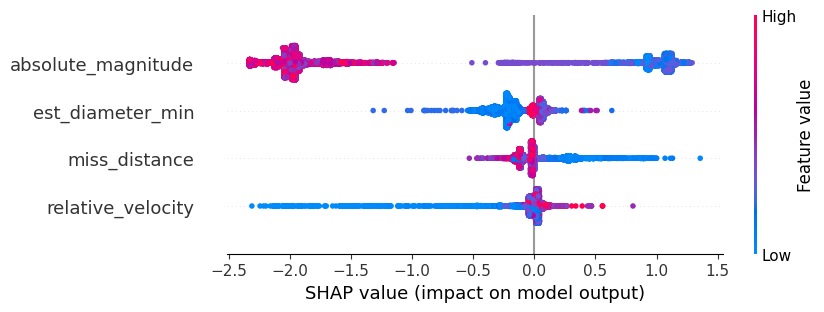

In [47]:
X_train_best = study.best_trial.user_attrs['X_train']
X_test_best = study.best_trial.user_attrs['X_test']
Y_train_best = study.best_trial.user_attrs['Y_train']
Y_test_best = study.best_trial.user_attrs['Y_test']

explanation = explainer(X_test_best)
shap.plots.beeswarm(explanation)

In [48]:
#run_server(storage)

In [49]:
os.getcwd()

'c:\\Users\\samud\\Documents\\Python_Learning\\Asteroids'